<div style="display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:210%;
            letter-spacing:0.5px;
            padding:10px;
            color:white;
            border-style: solid;
            border-color: black;
            text-align:center;">
<b>
 ⚕️🔬 Text Classification using N-Gram Feature Extraction 📝


**Summary**

Medical domain is in a data rich environment that a variety of knowledge can be extracted for positive outcomes. This notebook work will show multiclass classification of medical transcriptions using a real dataset. The objective of this paper is to classify medical transcriptions based on the medical specialty labels, namely Discharge Summary, Neurosurgery and ENT. Text normalisation has performed followed by extracting five different n-gram feature representations are. Moreover, three supervised learning classifiers were trained on each of the n-gram feature representations, namely K-Nearest Neighbours, Decision Tree, and Random Forest. The classification performance was evaluated by the metric score of macro F1. The best score achieved was over 0.8 macro F1 on testing set using tuned Random Forest and unigram feature vectors.

**Notebook Author**

Morris Lee 14/9/2022


**Concept of N-Gram**

In this notebook, n-gram will be used for feature extraction, which is the first NLP approach that introduced by Markov in 1913 [1]. An N-gram is an N-character slice of a longer string. The intuition of the n-gram model is that instead of computing a prediction based on entire corpus, one can approximate the prediction by only contiguous slices sequence of n words [2]. 
To explain feature extraction using n-gram with a demonstration of the sentence, “The student is alone happily”. The number of n-gram features can be calculated by k-n+1, where k is the number of words. The result is a bag-of-n-grams model [3] for a classifier to train the linguistic algorithm. Table I below shows the demonstration of different n-gram feature representations.

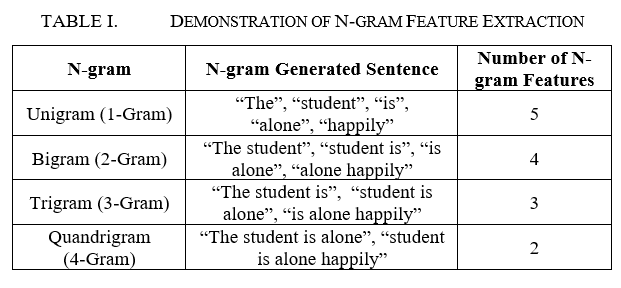

**Contents**

#### [1.0 Import Functions and EDA](#1.0)
* [1.1 Import Functions](#1.1)
* [1.2 Word Counts of Each Medical Specialty](#1.2)
* [1.3 Sample Size of Each Medical Specialty](#1.3)
* [1.4 General Cleaning](#1.4)

#### [2.0 Text Normalisation](#2.0)
* [2.1 Lower Case](#2.1)
* [2.2 Remove Punctuation and Numbers](#2.2)
* [2.3 Tokenisation](#2.3)
* [2.4 Stemming ](#2.4)

#### [3.0 Text N-Gram Feature Extraction](#3.0)
* [3.1 Extract 5 Types of N-Gram](#3.1)
* [3.2 Dimension of Each Feature Vector](#3.2)

#### [4.0 Text Classification Modelling](#4.0)
* [4.1 Visualising Classification Prediction](#4.1)
* [4.2 Dimensionality Reduction](#4.2)
* [4.3 Obtain Best Classifier and Feature Vector](#4.3)
* [4.4 Evaluate on Each Class Labels](#4.4)

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [5]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df

pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('Urdu-threat-detection-FIRE2022/Train_Clean.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)
        
def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')
        
df.head(3)

All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


/tmp/ipykernel_259115/3125563000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())


,tweets,label,s/g,word_count,char_count,word_density
0,بکواس مت,1,1,2,7,0.250000
1,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو,1,0,9,37,0.236842
2,آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے,1,1,11,52,0.207547


In [6]:
total_word_count = df['tweets'].str.split().str.len().sum()
print(f'The word count of all tweets is: {int(total_word_count)}')

The word count of all tweets is: 47869


# <b>1.4 <span style='color:red'>|</span> General Cleaning </b> <a class="anchor" id="1.4"></a>

In [7]:
# to print data shape
print(f'data shape is: {df.shape}')

# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

data shape is: (3560, 6)


tweets          0
label           0
s/g             0
word_count      0
char_count      0
word_density    0
dtype: int64

In [8]:
# to remove transcription rows that is empty
df = df[df['tweets'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560 entries, 0 to 3563
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweets        3560 non-null   object 
 1   label         3560 non-null   int64  
 2   s/g           3560 non-null   int64  
 3   word_count    3560 non-null   int64  
 4   char_count    3560 non-null   int64  
 5   word_density  3560 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 194.7+ KB


After dropping the null values, there are no null values for the tweets attribute. 

# <b>2.0 <span style='color:red'>|</span> Text Normalisation </b> <a class="anchor" id="2.0"></a>

Data normalisation will be conducted for the trascription. One of the reasons is to convert the transcript into standard format, which important for data extraction later. In this data normalisation task, following task will be executed, which are:
1. Lowe Case
2. Removing punctuation and numbers
3. Tokenisation of the transcription
4. Lemmatisation
5. Remove Stop Words

# <b>2.1 <span style='color:red'>|</span> Lower Case </b> <a class="anchor" id="2.1"></a>

In [9]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'tweets')
df.head(3)

,tweets,label,s/g,word_count,char_count,word_density
0,بکواس مت,1,1,2,7,0.250000
1,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو,1,0,9,37,0.236842
2,آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے,1,1,11,52,0.207547


# <b>2.2 <span style='color:red'>|</span> Remove Punctuation and Numbers </b> <a class="anchor" id="2.2"></a>

In [10]:
# To remove transcription punctuation and numbers

warnings.filterwarnings('ignore')
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'tweets')
df_no_punc =df.copy()
df.head(3)

,tweets,label,s/g,word_count,char_count,word_density
0,بکواس مت,1,1,2,7,0.250000
1,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو,1,0,9,37,0.236842
2,آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے,1,1,11,52,0.207547


# <b>2.3 <span style='color:red'>|</span> Tokenisation </b> <a class="anchor" id="2.3"></a>


In [11]:
# to tokenise transcription

# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'tweets')
df_experiment =df.copy()
df.head(3)

,tweets,label,s/g,word_count,char_count,word_density,tokenised
0,بکواس مت,1,1,2,7,0.250000,"[بکواس, مت]"
1,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو,1,0,9,37,0.236842,"[تمہاری, ہیجڑا, فورس, نہتے, سامنے, بکری, بنی, ڈوب, مرو]"
2,آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے,1,1,11,52,0.207547,"[آفیسر, سمیتبھارتی, فوجی, جہنم, واصلبنکرز, تباہ, بھارت, کو, پتہ, لگ, جائے]"


# <b>2.5 <span style='color:red'>|</span> Stop Words Removal </b> <a class="anchor" id="2.5"></a>


Removing stop words from the feature space, otherwise it will affect the classifier performance as the collection frequency is often high

In [15]:
# Showing the list of the English stop words, it has a number of 179 stop words in this list

stop = stopwords.words('urdu')
print(f"There are {len(stop)} stop words \n")
print(stop)

There are 548 stop words 

['ثھی', 'خو', 'گی', 'اپٌے', 'گئے', 'ثہت', 'طرف', 'ہوبری', 'پبئے', 'اپٌب', 'دوضری', 'گیب', 'کت', 'گب', 'ثھی', 'ضے', 'ہر', 'پر', 'اش', 'دی', 'گے', 'لگیں', 'ہے', 'ثعذ', 'ضکتے', 'وٍ', 'تھی', 'اى', 'دیب', 'لئے', 'والے', 'یہ', 'ثدبئے', 'ضکتی', 'ًے', 'تھب', 'اًذر', 'رریعے', 'لگی', 'ہوبرا', 'ہوًے', 'ثبہر', 'ضکتب', 'ًہیں', 'تو', 'اور', 'رہب', 'لگے', 'ہوضکتب', 'ہوں', 'کب', 'ہوبرے', 'توبم', 'کیب', 'ایطے', 'رہی', 'هگر', 'ہوضکتی', 'ہیں', 'کریں', 'ہو', 'تک', 'کی', 'ایک', 'رہے', 'هیں', 'ہوضکتے', 'کیطے', 'ہوًب', 'تت', 'کہ', 'ہوا', 'آئے', 'ضبتھ', 'ًب', 'تھے', 'کیوں', 'ہوتب', 'ًہ', 'خت', 'کے', 'پھر', 'ثغیر', 'خبرہے', 'رکھ', 'کیطب', 'کوئی', 'رریعے', 'ثبرے', 'خب', 'اضطرذ', 'ثلکہ', 'خجکہ', 'رکھتب', 'کیطرف', 'ثراں', 'خبرہب', 'رریعہ', 'کطی', 'اضکب', 'ثٌذ', 'خص', 'رکھتبہوں', 'کیلئے', 'ثبئیں', 'توہیں', 'دوضرے', 'کررہی', 'اضکی', 'ثیچ', 'خوکہ', 'رکھتی', 'کیوًکہ', 'دوًوں', 'کررہے', 'خبرہی', 'ثرآں', 'اضکے', 'پچھلا', 'خیطب', 'رکھتے', 'کےثعذ', 'توہی', 'دوراى', 'کررہب', 'یہبں', 'ٓ آش', 'اًہ

In [16]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'tokenised')
df.head(2)

,tweets,label,s/g,word_count,char_count,word_density,tokenised,stemmed_without_stop
0,بکواس مت,1,1,2,7,0.250000,"[بکواس, مت]",بکواس مت
1,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو,1,0,9,37,0.236842,"[تمہاری, ہیجڑا, فورس, نہتے, سامنے, بکری, بنی, ڈوب, مرو]",تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو


After the 5 data normalisation steps, each transcription record is now in a standard format, which is ready for the n-gram features extraction later. Hence, we should use the attribute 'stemmed_withou_stop' as the predictor attribute and drop other redundant attributes, namely 'transcription', 'tokenized_transcription' and 'stemmed'.

In [18]:
df =df.drop(['tweets', 'tokenised'], axis=1)
df.head()

,label,s/g,word_count,char_count,word_density,stemmed_without_stop
0,1,1,2,7,0.250000,بکواس مت
1,1,0,9,37,0.236842,تمہاری ہیجڑا فورس نہتے سامنے بکری بنی ڈوب مرو
2,1,1,11,52,0.207547,آفیسر سمیتبھارتی فوجی جہنم واصلبنکرز تباہ بھارت کو پتہ لگ جائے
3,1,1,6,25,0.230769,غدار منافق میر اللہ تمہیں زلیل
4,1,0,23,83,0.273810,اگست آپ بھارت کو کیا پیغام دینا چاہیں میرا پیغام ھے کشمیر سے نکل جاو ورنہ کتے موت مارے جاو کشمیر ہمارا ھے


In [20]:
total_word_count_normalised = df['stemmed_without_stop'].str.split().str.len().sum()
print(f'The word count of tweets after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of tweets after normalised is: 47869
0.0% less word


le = preprocessing.LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()

# <b>3.0 <span style='color:red'>|</span> Text N-Gram Feature Extraction </b> <a class="anchor" id="3.0"></a>

We will use sklearn class 'CountVectoriser' to extract different n-grams features. In order to do so, the transcription should be converted into a list format, rather than a dataframe. For the purpose of converting into a flat list (i.e., there is no inner list), the function of 'flat_list' that defined above is used.

In [21]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

def to_list(df, attribute):
    # Select the normalised transcript column 
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'stemmed_without_stop')

# <b>3.1 <span style='color:red'>|</span> Extract 5 Types of N-Gram </b> <a class="anchor" id="3.1"></a>


CountVectorizer is used to convert a collection of transcript documents to a matrix of n-gram features. To explain the ngram_range, all values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

In [22]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [23]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items(): 
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

# <b>3.2 <span style='color:red'>|</span> Dimension of Each Feature Vector </b> <a class="anchor" id="3.2"></a>

In [24]:
dataframes = {'unigram':temp[0], 
              'unigram_bigram':temp[1], 
              'bigram':temp[2], 
              'bigram_trigram':temp[3], 
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(3560, 7642)"
1,unigram_bigram,"(3560, 39164)"
2,bigram,"(3560, 31522)"
3,bigram_trigram,"(3560, 69252)"
4,trigram,"(3560, 37730)"


After the feature extraction process, 5 kinds of n-gram features are extracted. It is interesting to notice that when the number of 'n' getting higher (i.e, n=1:unigram, n=2:bigram, n=3:trigram), there is a higer number of columns. This is due to it is getting harder to find similar features that can be stored in similar column when it has a longer connected words as one featuer. If the feature is unique, it will automatically append additional column to store the feaure.

In [25]:
# to retrieve a unigram feature vector
dataframes['unigram']

<3560x7642 sparse matrix of type '<class 'numpy.int64'>'
	with 44970 stored elements in Compressed Sparse Row format>

# <b>4.0 <span style='color:red'>|</span> Text Classification Modelling </b> <a class="anchor" id="4.0"></a>

In [27]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
random_state_number =8888
df_target =df[['label']].values.ravel()

In [28]:
metrics = {
    'f1':[f1_score, 'f1_macro'], 
    'precision': [precision_score, 'precision_macro'], 
    'recall': [recall_score, 'recall_macro']
}

# get evaluation result

def get_performance(param_grid, base_estimator, dataframes):
    df_name_list =[]; best_estimator_list=[]; best_score_list=[]; test_predict_result_list=[];
    metric_list = [];
    
    for df_name, df in dataframes.items():
        
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
        for _, metric_dict in metrics.items():
            sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1],random_state=random_state_number,
                                      factor=2).fit(X_train, y_train)

            best_estimator = sh.best_estimator_
            clf = best_estimator.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            test_predict_result = metric_dict[0](y_test, prediction, average='macro')

            df_name_list.append(df_name) ; best_estimator_list.append(best_estimator) ; 
            best_score_list.append(sh.best_score_) ; 
            test_predict_result_list.append(test_predict_result) ;metric_list.append(metric_dict[1])
            
            
    model_result = pd.DataFrame({'Vector':df_name_list,'Metric':metric_list,
                               'Calibrated Estimator':best_estimator_list,
                               'Best CV Metric Score':best_score_list, 'Test Predict Metric Score': test_predict_result_list})
    return model_result


# <b>4.1 <span style='color:red'>|</span> Visualising Classification Prediction </b> <a class="anchor" id="4.1"></a>

In [29]:
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(dataframes[vector_type].todense())
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)
    
    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()
    
    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)
    
    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)
    
    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator
    
    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):
        
        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

In [30]:
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
rfc_result = get_performance(param_grid, base_estimator, dataframes)
rfc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.698943,0.699417
1,unigram,precision_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.700249,0.700804
2,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.693874,0.703109
3,unigram_bigram,f1_macro,"(DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.692376,0.695936
4,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.701219,0.702183
5,unigram_bigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.683417,0.683266
6,bigram,f1_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.596838,0.584485
7,bigram,precision_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.681501,0.680969
8,bigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.626353,0.623420
9,bigram_trigram,f1_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1...",0.577679,0.584990


In [31]:
def get_best_vector_clf(knn_result):

    temp = knn_result[knn_result['Metric'] =='f1_macro']
    temp2 = temp.iloc[temp['Best CV Metric Score'].idxmax()].to_frame().T
    best_vector = temp2['Vector'].values[0]
    best_clf = temp2['Calibrated Estimator'].values[0]\
    
    return best_vector, best_clf

best_vector, best_clf =  get_best_vector_clf(rfc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

NameError: name 'le' is not defined

# <b>4.2 <span style='color:red'>|</span>  Dimensionality Reduction </b> <a class="anchor" id="4.2"></a>

In [32]:
df_temp = rfc_result[rfc_result['Metric'] =='f1_macro']
# df_temp['Calibrated Estimator']
vector_rfc = df_temp[['Vector','Calibrated Estimator']].set_index('Vector').to_dict()['Calibrated Estimator']
vector_rfc

{'unigram': RandomForestClassifier(max_depth=38, random_state=8888),
 'unigram_bigram': RandomForestClassifier(max_depth=37, random_state=8888),
 'bigram': RandomForestClassifier(max_depth=30, min_samples_split=150, random_state=8888),
 'bigram_trigram': RandomForestClassifier(max_depth=30, min_samples_split=180, random_state=8888),
 'trigram': RandomForestClassifier(min_samples_split=170, random_state=8888)}

In [33]:
supported_columns_dict = {}
for df_name, df in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(dataframes[df_name], df_target, test_size=0.2, random_state=random_state_number)

    selector = SelectFromModel(estimator=vector_rfc[df_name]).fit(X_train, y_train)
    
    filter_columns = selector.get_support()
    dataframes[df_name] = dataframes[df_name][:, filter_columns]
    
shape_dim = [] ; df_names = []
for df_name, df in dataframes.items():
    shape_dim.append(df.shape)
    df_names.append(df_name)
n_gram_df_dim = pd.DataFrame({'N-Gram Feature Vector':df_names, 'Data Dimension':shape_dim}) 
n_gram_df_dim

,N-Gram Feature Vector,Data Dimension
0,unigram,"(3560, 1267)"
1,unigram_bigram,"(3560, 5809)"
2,bigram,"(3560, 1628)"
3,bigram_trigram,"(3560, 1925)"
4,trigram,"(3560, 10454)"


findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


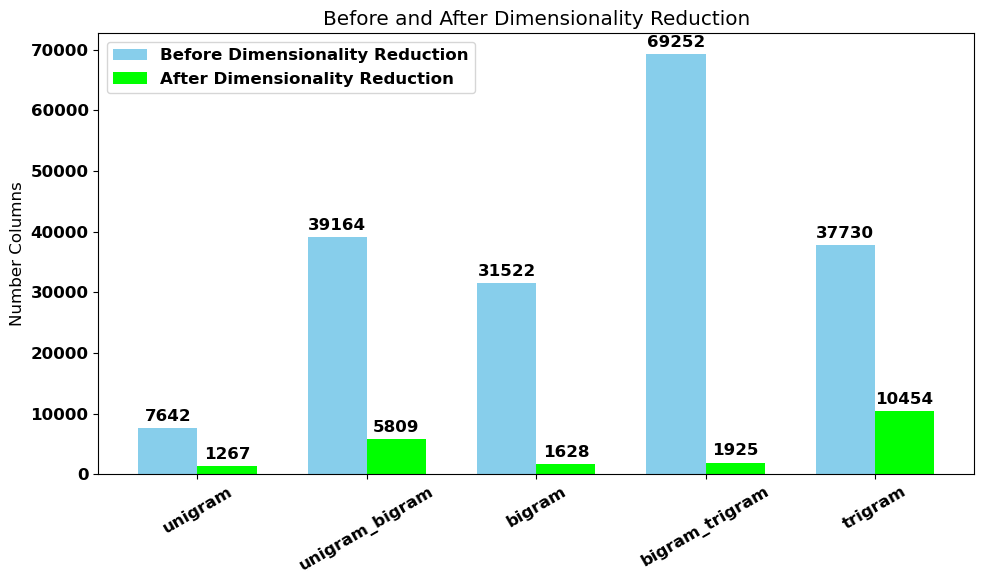

In [34]:
labels = n_gram_df_dim['N-Gram Feature Vector'].values
b4 = [shape[1] for shape in n_gram_df['Data Dimension'].values]
af = [shape[1] for shape in n_gram_df_dim['Data Dimension'].values]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, b4, width, label='Before Dimensionality Reduction', color='skyblue')
rects2 = ax.bar(x + width/2, af, width, label='After Dimensionality Reduction', color='lime')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number Columns')
ax.set_title('Before and After Dimensionality Reduction')
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [35]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19,21]}
base_estimator = KNeighborsClassifier()
knn_result = get_performance(param_grid, base_estimator, dataframes)
knn_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,KNeighborsClassifier(),0.582535,0.573390
1,unigram,precision_macro,KNeighborsClassifier(n_neighbors=7),0.633801,0.592996
2,unigram,recall_macro,KNeighborsClassifier(),0.602620,0.584934
3,unigram_bigram,f1_macro,KNeighborsClassifier(n_neighbors=11),0.517419,0.495086
4,unigram_bigram,precision_macro,KNeighborsClassifier(n_neighbors=11),0.661364,0.615423
5,unigram_bigram,recall_macro,KNeighborsClassifier(n_neighbors=11),0.578521,0.560825
6,bigram,f1_macro,KNeighborsClassifier(),0.555821,0.571658
7,bigram,precision_macro,KNeighborsClassifier(n_neighbors=13),0.668543,0.632166
8,bigram,recall_macro,KNeighborsClassifier(),0.595543,0.604146
9,bigram_trigram,f1_macro,KNeighborsClassifier(),0.564468,0.559707


best_vector, best_clf =  get_best_vector_clf(knn_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [36]:
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}
base_estimator = DecisionTreeClassifier(random_state=random_state_number)
dtc_result = get_performance(param_grid, base_estimator, dataframes)
dtc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"DecisionTreeClassifier(min_samples_split=10, random_state=8888)",0.642943,0.627720
1,unigram,precision_macro,"DecisionTreeClassifier(max_depth=30, min_samples_split=5, random_state=8888)",0.648988,0.652014
2,unigram,recall_macro,"DecisionTreeClassifier(min_samples_split=10, random_state=8888)",0.643139,0.628002
3,unigram_bigram,f1_macro,"DecisionTreeClassifier(min_samples_split=10, random_state=8888)",0.640588,0.623450
4,unigram_bigram,precision_macro,"DecisionTreeClassifier(max_depth=30, min_samples_split=3, random_state=8888)",0.650482,0.664840
5,unigram_bigram,recall_macro,"DecisionTreeClassifier(min_samples_split=16, random_state=8888)",0.641982,0.643485
6,bigram,f1_macro,"DecisionTreeClassifier(min_samples_split=20, random_state=8888)",0.677497,0.616926
7,bigram,precision_macro,"DecisionTreeClassifier(max_depth=35, min_samples_split=3, random_state=8888)",0.671680,0.671318
8,bigram,recall_macro,"DecisionTreeClassifier(min_samples_split=20, random_state=8888)",0.683437,0.632425
9,bigram_trigram,f1_macro,"DecisionTreeClassifier(max_depth=35, min_samples_split=20, random_state=8888)",0.538196,0.535982


best_vector, best_clf =  get_best_vector_clf(dtc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [37]:
df_result = pd.concat([knn_result, 
                      dtc_result,
                      rfc_result
                      ]
                     ).reset_index(drop=True)

df_result.groupby(['Metric']).max()

,Vector,Best CV Metric Score,Test Predict Metric Score
Metric,,,
f1_macro,unigram_bigram,0.698943,0.699417
precision_macro,unigram_bigram,0.740739,0.702183
recall_macro,unigram_bigram,0.693874,0.703109


# <b>4.3 <span style='color:red'>|</span>  Obtain Best Classifier and Feature Vector </b> <a class="anchor" id="4.3"></a>

In [38]:
def get_best_result(df_result, metric_score):
    df_result_t = df_result[df_result.Metric== 'precision_macro']
    precision_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'recall_macro']
    recall_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T
    
    df_result_t = df_result[df_result.Metric== 'f1_macro']
    f1_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    return pd.concat([precision_macro_df,recall_macro_df,f1_macro_df])

In [39]:
best_cv_result = get_best_result(df_result, 'Best CV Metric Score')
display(best_cv_result)
temp = best_cv_result[best_cv_result['Metric'] == 'f1_macro']
best_clf = temp['Calibrated Estimator'].values[0]
best_vector = temp['Vector'].values[0]

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
13,trigram,precision_macro,KNeighborsClassifier(),0.740739,0.673557
32,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.693874,0.703109
30,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.698943,0.699417


In [40]:
get_best_result(df_result, 'Test Predict Metric Score')

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
34,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=37, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.701219,0.702183
32,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=150,\n random_state=1...",0.693874,0.703109
30,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.698943,0.699417


# <b>4.4 <span style='color:red'>|</span>  Evaluate on Each Class Labels </b> <a class="anchor" id="4.4"></a>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(dataframes[best_vector], df_target, test_size=0.2, \
                                                    random_state=random_state_number)
clf = best_clf.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
target_names = ["Threatening","Non-Threatning"]
print(classification_report(y_test,y_test_pred,target_names=target_names))

                precision    recall  f1-score   support

   Threatening       0.66      0.72      0.69       344
Non-Threatning       0.71      0.65      0.68       368

      accuracy                           0.68       712
     macro avg       0.68      0.68      0.68       712
  weighted avg       0.68      0.68      0.68       712



sample_predict = pd.DataFrame({'Actual Y Test': le.inverse_transform(y_test),'Best Prediction':le.inverse_transform(y_test_pred)})
sample_predict.head(20)